## 1a. [Deprecated; see notebook 2] Downloading ERA5-Land hourly data for locations (coordinates) using GEE
This notebook demonstrates how to sample raw ERA5-Land data from Google Earth Engine. Eventual improvments will tidy this data up for use in ELM. 
There is a step involved here where you must wait for GEE's computers to crank through the request, then you'll need to move a file from your Google Drive to your local machine. There are no great ways to automate this, sorry.

We will sample from the site locations listed in this [NGEE repo](https://github.com/NGEE-Arctic/cc1_ngee_p4_sites).

In [1]:
import ee
import pandas as pd
from ngeegee import e5l_utils as eu
from ngeegee import utils
from ngeegee import metadata as md
from pathlib import Path

# Make sure to Initialize with the correct project name (do not use mine--it won't work for you)
ee.Initialize(project='ee-jonschwenk')

# Build our points dictionary
points = {'abisko' : (68.35, 18.78333),
        'tvc' : (68.742, -133.499),
        'toolik' : (68.62758, -149.59429),
        'chars' :  (69.1300, -105.0415),
        'qhi' : (69.5795, -139.0762),
        'sam' : (72.22, 126.3),
        'sjb' : (78.92163, 11.83109)}

### Set up our request via a dictionary of parameters
The only tricky thing here is specifying the bands (variables) you want. You have two options: 1) just set `gee_bands` to `all` to fetch all 69 bands, or provide a `list` of bands. If you aren't sure which bands are available, you can run `eu.e5lh_bands()['band_name']`:

In [2]:
print(md.e5lh_bands()['band_name'])

0        dewpoint_temperature_2m
1                 temperature_2m
2               skin_temperature
3       soil_temperature_level_1
4       soil_temperature_level_2
                 ...            
64       snow_evaporation_hourly
65     sub_surface_runoff_hourly
66         surface_runoff_hourly
67      total_evaporation_hourly
68    total_precipitation_hourly
Name: band_name, Length: 69, dtype: object


There is also an option to request "elm_required" bands when we send the request, so that's what we'll use here.

In [3]:
params = {
    "start_date": "2022-01-01", # 1950-01-01 is the earliest possible; for speed we just sample a couple years here
    "end_date": "2100-01-01", # If your end date is longer than what's available, it will just truncate at the last available date. Here I've used the year 2100 to ensure we download all data.
    "gee_bands": 'elm_required', # You can also specify 'all' to get all bands/variables, or provide a list of variables (e.g. ['temperature_2m', 'total_evaporation_hourly', 'soil_temperature_level_1'])
    "points": points,  
    "gdrive_folder": "NGEE_test",  # Google Drive folder name - will be created if it doesn't exist
    "filename": "ngee_test_era5_timeseries"  # Output CSV file name
}

# Send the job to GEE!
eu.sample_e5lh_at_points(params)

'Export task started: ngee_test_era5_timeseries (Check Google Drive or Task Status in the Javascript Editor for completion.)'

### Now we wait.
You've sent a Task to Google Earth Engine. You can check on its state using the [GEE Javascript code editor](http://code.earthengine.google.com) by clicking the `Tasks` tab in the upper-right panel.
Eventually it will finish, and your csv will show up where you told GEE to put it: `gdrive_folder/filename`.
It should not take more than a few hours to fetch all variables (68 total, I think) for all ~75 years, but this depends on how many points you've requested, how many other jobs you may have running, and the current general load on Google Earth Engine. In my testing, it took 2 hours to fetch two variables at one point from 1950-2025. It likely won't take much longer to fetch more variables, as the time suck is that GEE has to load each hourly ERA5-Land image.
Once that file is created in your GDrive, download it to your local machine and hammer away!

## Some examination of the data
Eventually, a `.csv` appeared in my Google Drive foler (`NGEE_test\ngee_test_era5_timeseries`). I downloaded it and have included it in this repo just so we can inspect it a bit.

In [4]:
df = pd.read_csv(utils._ROOT_DIR / 'notebooks' / 'notebook_data' / 'ngee_test_era5_timeseries.csv')
print(df.columns)

Index(['pid', 'date', 'temperature_2m', 'u_component_of_wind_10m',
       'v_component_of_wind_10m', 'surface_solar_radiation_downwards_hourly',
       'surface_thermal_radiation_downwards_hourly',
       'total_precipitation_hourly', 'surface_pressure',
       'dewpoint_temperature_2m'],
      dtype='object')


We see columns for each of the variables (bands) we requested (e.g. `temperature_2m`, `total_precipitation`, etc.). We also see a date column that includes the hour of day. Finally, there's a `pid` column. This corresponds to the names we defined in the `params['points']` dictionary. Let's double-check that:

In [5]:
print(set(df['pid']))

{'chars', 'tvc', 'toolik', 'sam', 'sjb', 'qhi', 'abisko'}


The `.csv` is exported "flat" with respect to the sites. If we want to create a dataframe for each site, for example, we can write:

In [6]:
dfs_separated = {k : group for k, group in df.groupby('pid')}
print(dfs_separated['abisko'])

           pid              date  temperature_2m  u_component_of_wind_10m  \
0       abisko  2022-01-01 00:00      253.960236                 1.675461   
7       abisko  2022-01-01 01:00      255.035751                 1.755249   
14      abisko  2022-01-01 02:00      254.869659                 1.744003   
21      abisko  2022-01-01 03:00      255.266083                 1.772507   
28      abisko  2022-01-01 04:00      256.068604                 1.824921   
...        ...               ...             ...                      ...   
192493  abisko  2025-02-19 19:00      267.342255                 2.904938   
192500  abisko  2025-02-19 20:00      267.503448                 2.822266   
192507  abisko  2025-02-19 21:00      267.441833                 2.587051   
192514  abisko  2025-02-19 22:00      267.407745                 2.458008   
192521  abisko  2025-02-19 23:00      267.623978                 2.271194   

        v_component_of_wind_10m  surface_solar_radiation_downwards_hourly  

It's wise to re-sort each dataframe based on time, and we can drop the 'pid' field now.

In [7]:
for site, site_df in dfs_separated.items():
    site_df.sort_values(by='date', inplace=True)
    site_df.drop('pid', axis=1, inplace=True)
    dfs_separated[site] = site_df

Let's plot the temperature at each site as a final validation.

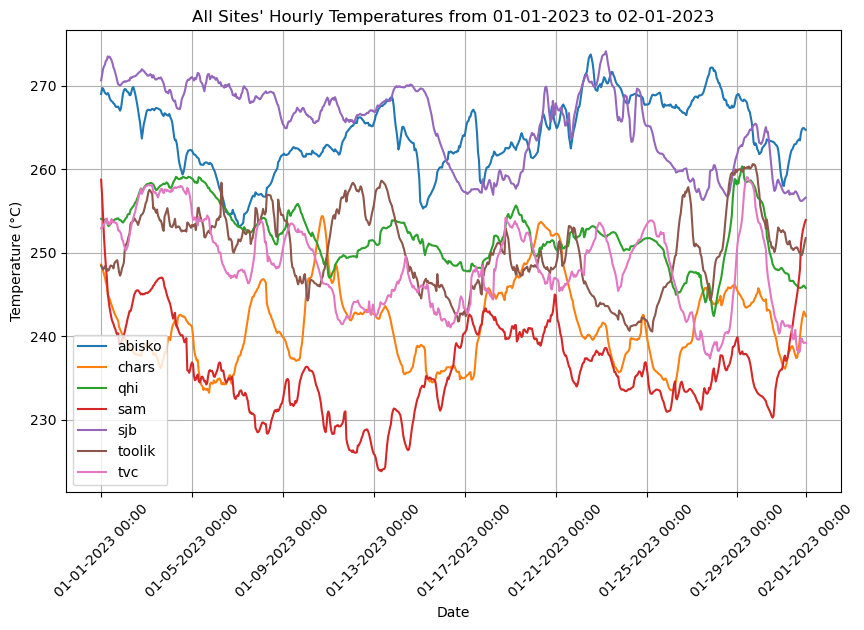

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define the date range for filtering
start_date = pd.to_datetime("01-01-2023", format="%m-%d-%Y")
end_date = pd.to_datetime("02-01-2023", format="%m-%d-%Y")

plt.figure(figsize=(10, 6))
for site, df in dfs_separated.items():
    # Ensure 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Filter data within the specified date range
    df_filtered = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    # Plot temperature for each site
    plt.plot(df_filtered['date'], df_filtered['temperature_2m'], label=site)

plt.xlabel("Date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y %H:%M'))  # MM-DD-YYYY HH:MM format
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust ticks

plt.ylabel("Temperature (°C)")
plt.title(f"All Sites' Hourly Temperatures from {start_date.strftime('%m-%d-%Y')} to {end_date.strftime('%m-%d-%Y')}")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
